In [3]:
import pandas as pd
import os
import torch
from torch.utils.data import DataLoader
from torch import nn
from fastmri.models import Unet
from utils_train import fastmri_dataset
from utils_inf import load_model, run_inference
import matplotlib.pyplot as plt

In [52]:
config = {
    'model_path': "/home/yusuf/Desktop/projects/scripts/checkpoints/fold8/epoch=34_valloss=0.03789634967246388.pt",
    'filenames_csv': "test_file_lists/test_filesAXT1POST.csv",
    'data_dir': "/home/yusuf/Desktop/projects/data/fastmri/multicoil_val",
    'mask_type': "equispaced",
    'center_fractions': [0.08],
    'accelerations': [8],
    'batch_size' : 1,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(in_chans=1, out_chans=1, chans=32, num_pool_layers=4).to(device)
model = nn.DataParallel(model).to(device)

model = load_model(config["model_path"], model)

test_csv = pd.read_csv(config["filenames_csv"])
test_files = test_csv.file_name.to_list()

test_files = os.listdir(config['data_dir'])[:10]
test_dataset = fastmri_dataset(config['data_dir'], test_files, config['mask_type'], config['center_fractions'], config['accelerations'])
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

In [54]:
def inference(model, test_loader, device):
    model.eval()


    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):  # Targets are optional during inference
            inputs = inputs.unsqueeze(1).to(device)  # Add channel dimension
            targets = targets.unsqueeze(1).to(device)
            outputs = model(inputs)

            reconstructions = outputs.squeeze(1).cpu().numpy()
            inpimages = inputs.squeeze(1).cpu().numpy()
            gtimages = targets.squeeze(1).cpu().numpy()

            for j, (recon, inp, target) in enumerate(zip(reconstructions, inpimages, gtimages)):
                idx = i * len(reconstructions) + j

                plt.figure(figsize=(18, 6))

                plt.subplot(1, 3, 1)
                plt.imshow(inp, cmap="gray")
                plt.title(f"Input || 8-fold")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(target, cmap="gray")
                plt.title(f"Target")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(recon, cmap="gray")
                plt.title(f"Reconstruction")
                plt.axis("off")

            if i==10:
                break

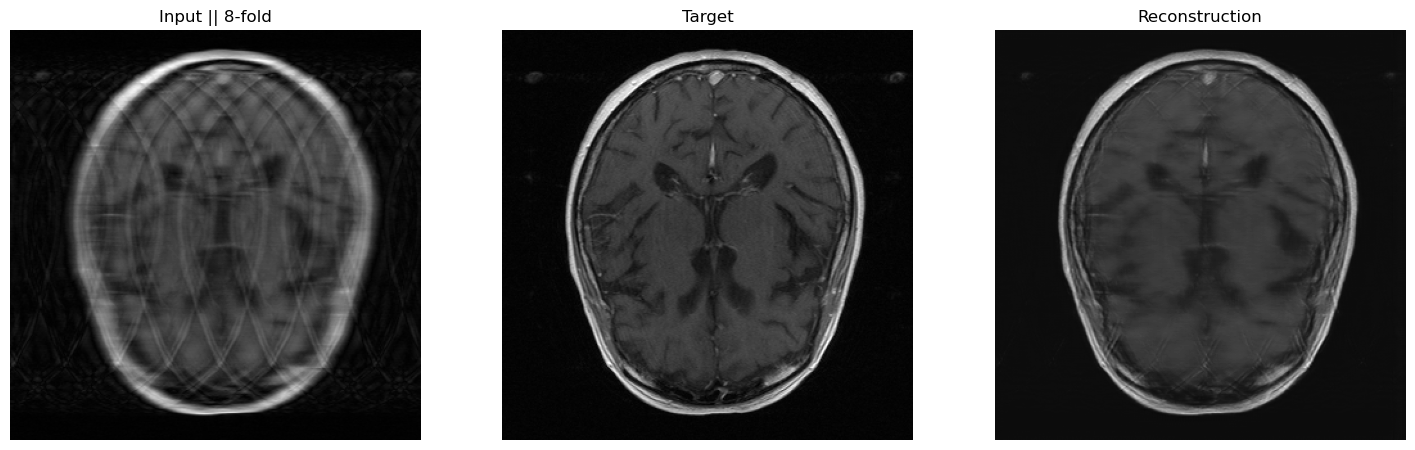

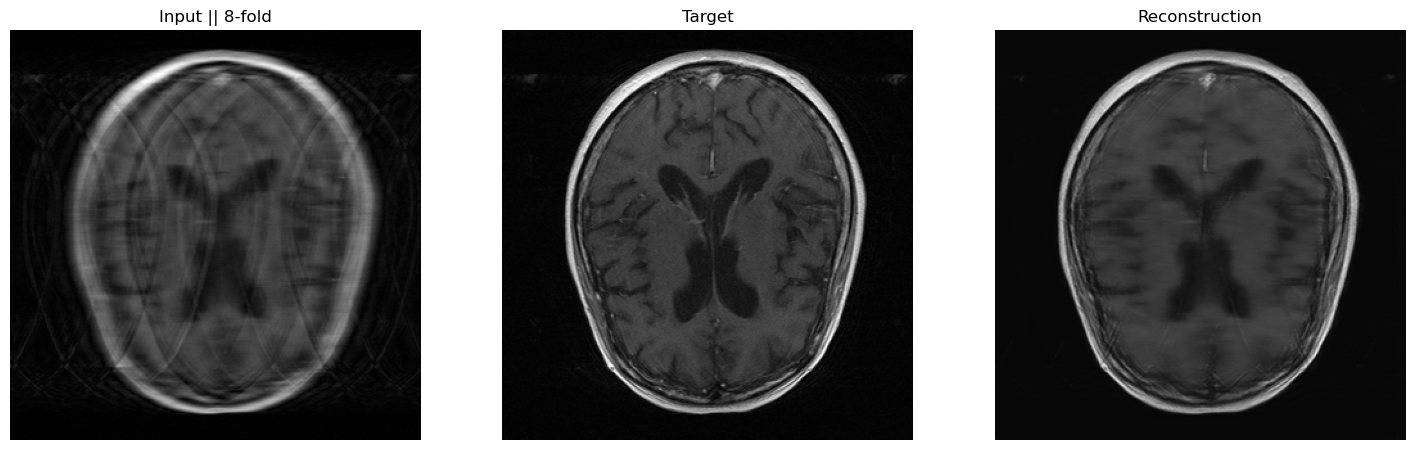

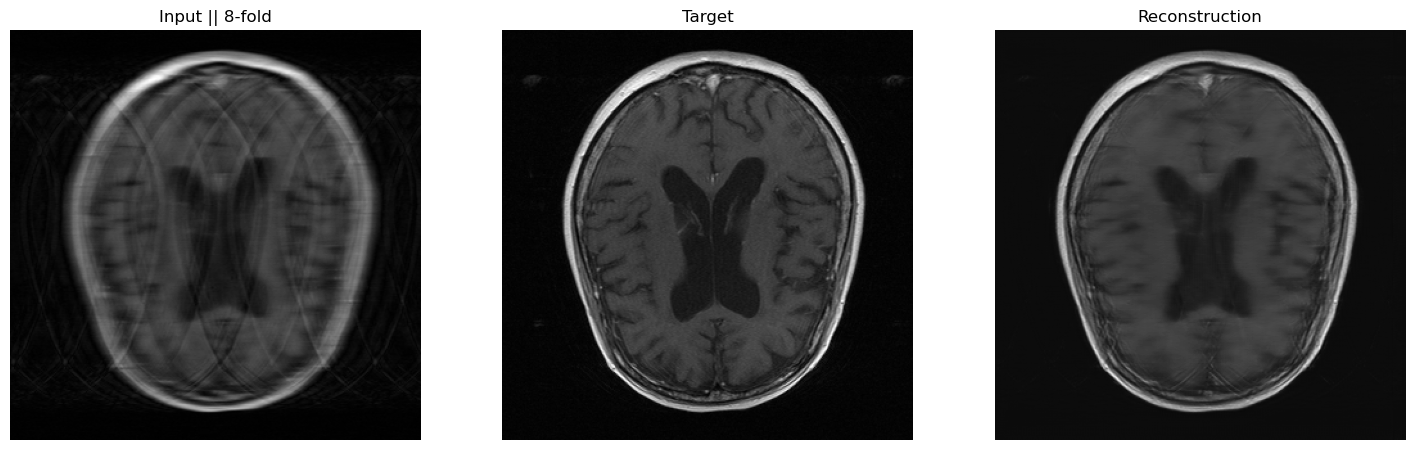

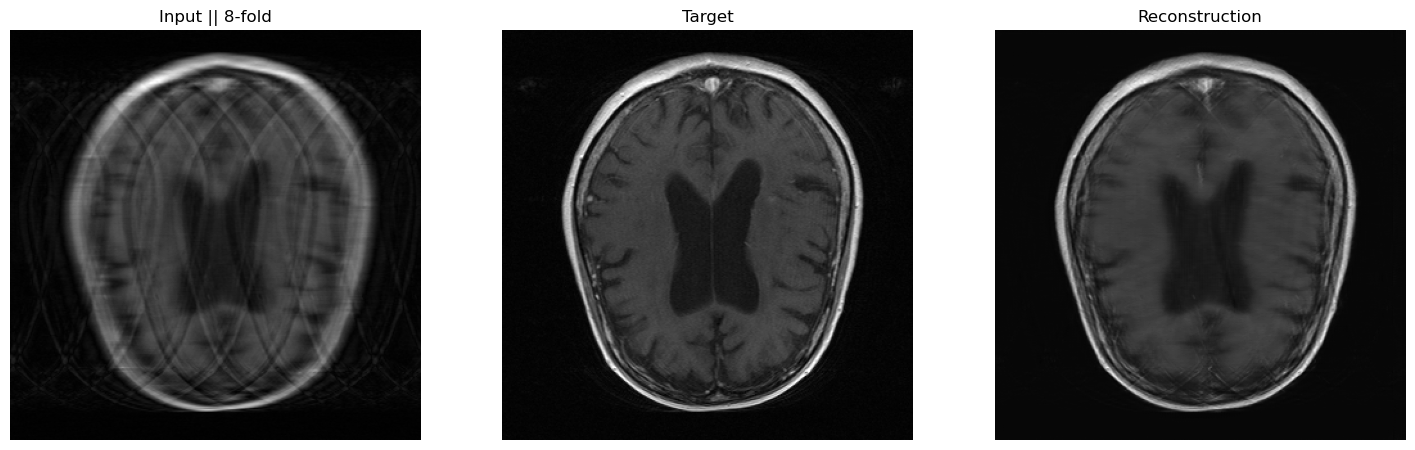

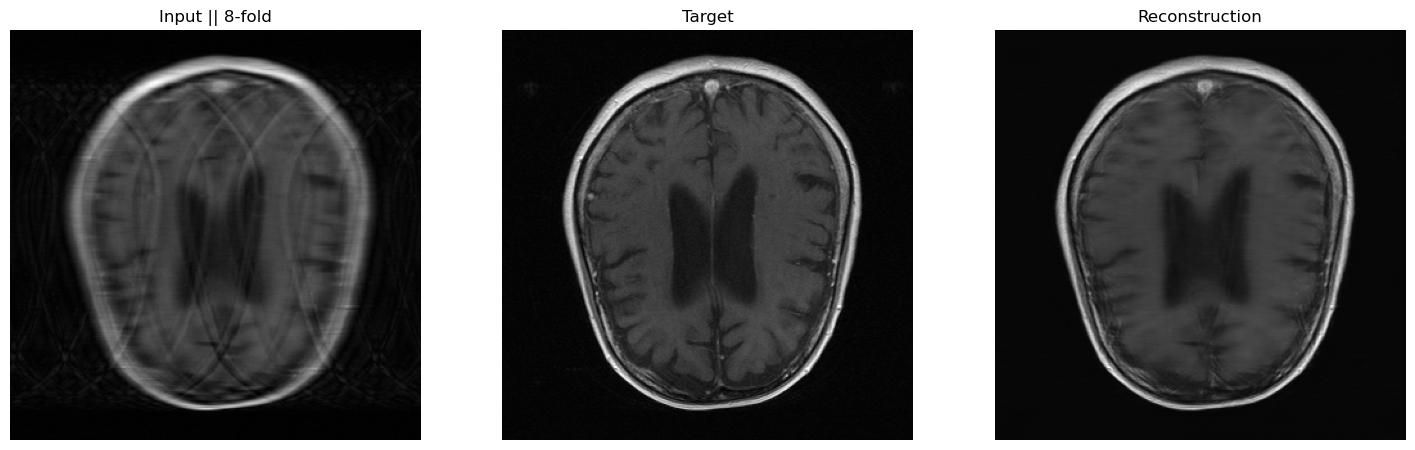

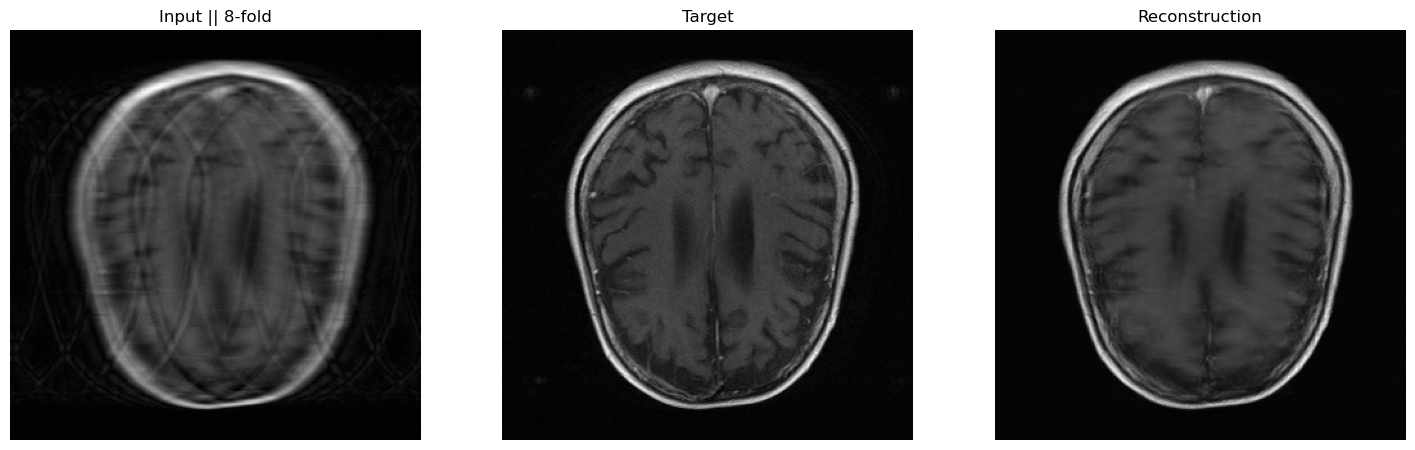

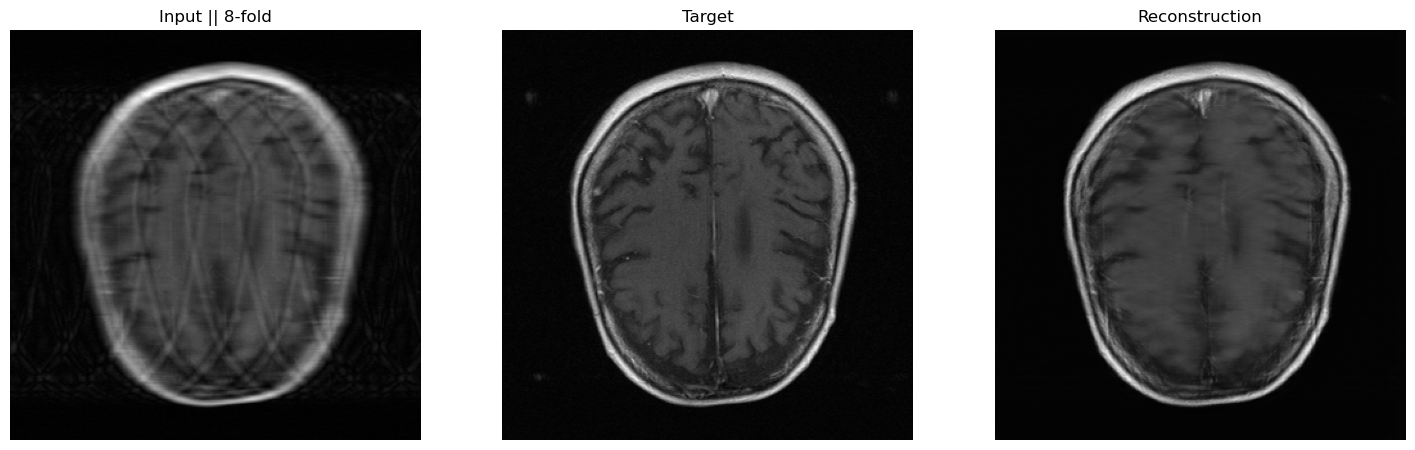

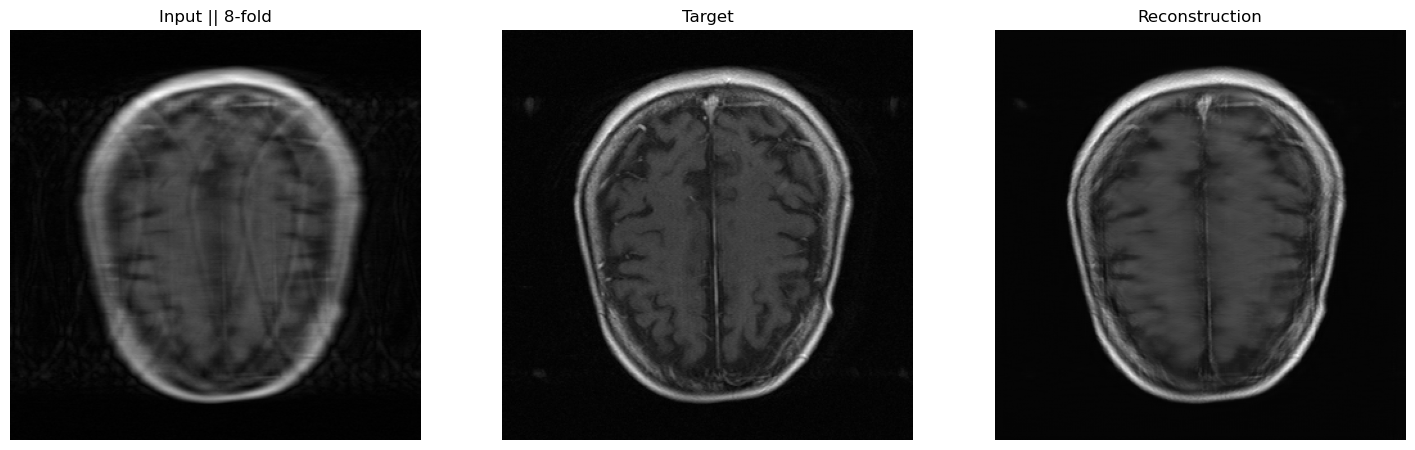

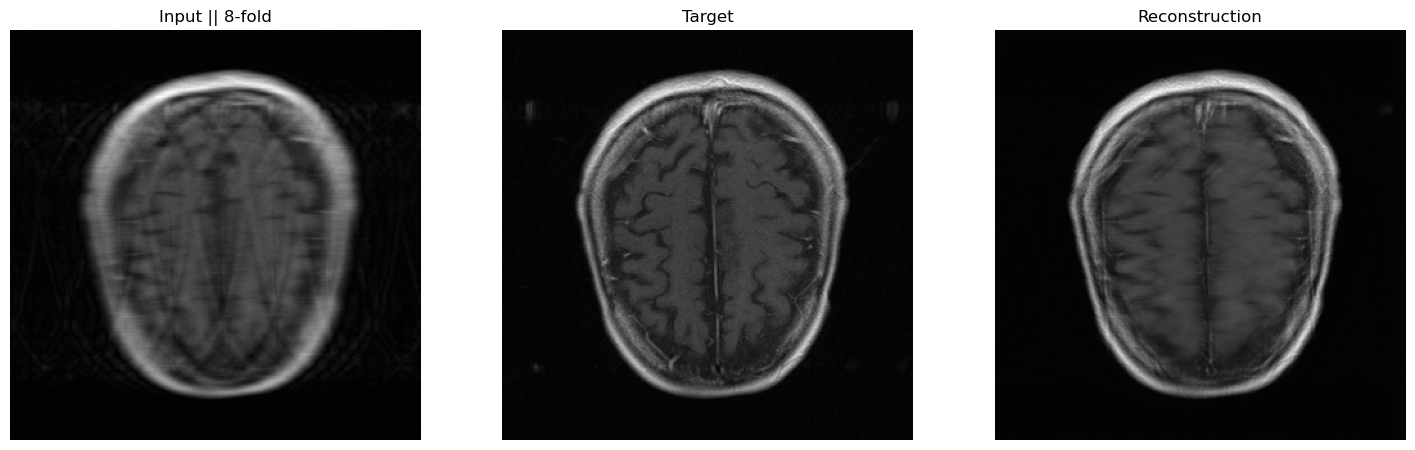

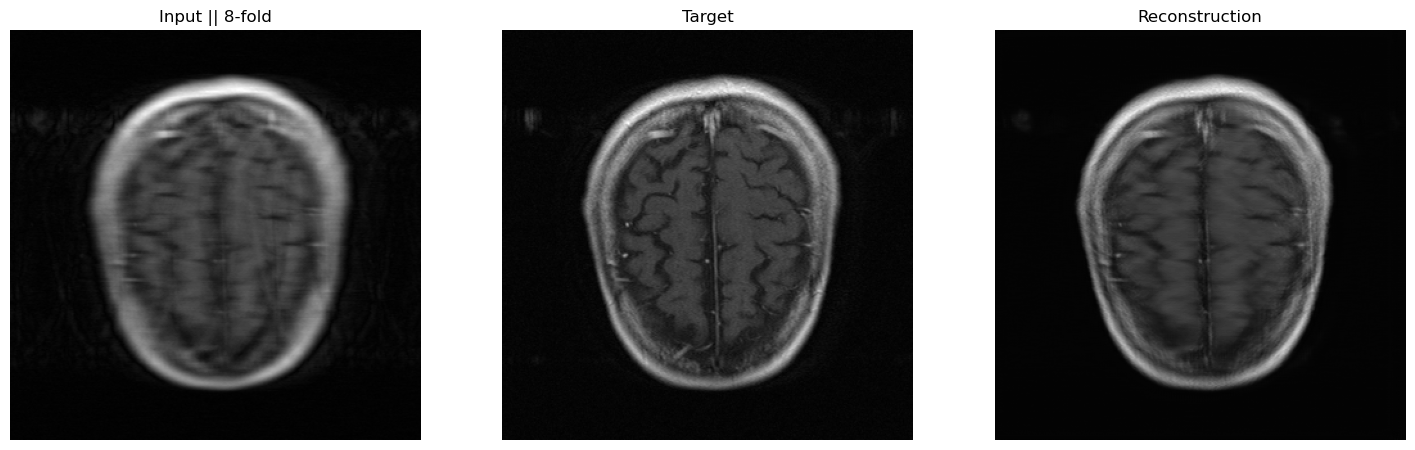

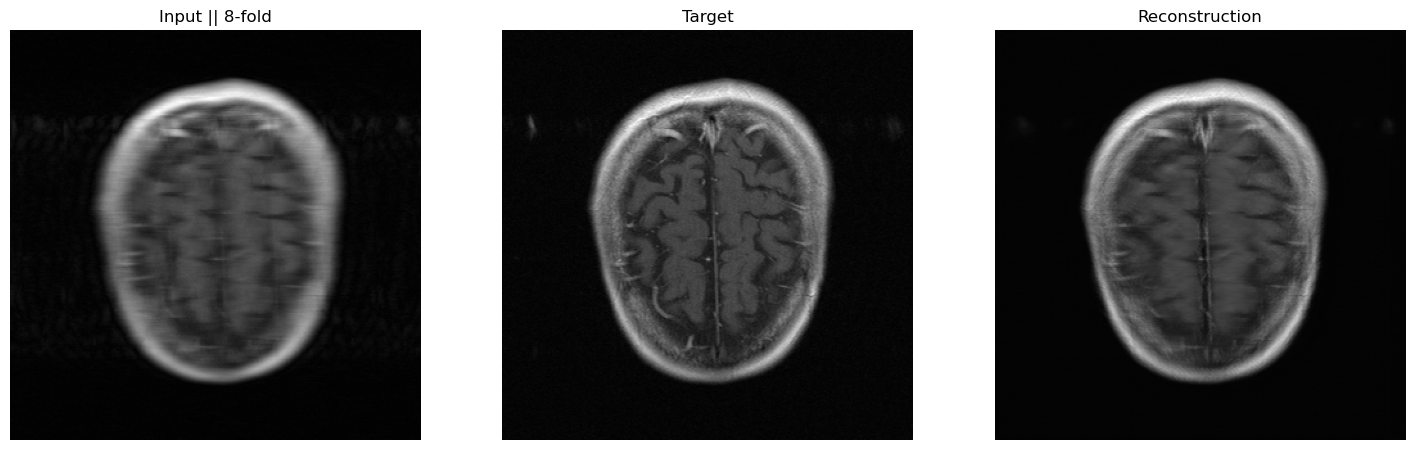

In [55]:
inference(model, test_loader, device)